<a href="https://colab.research.google.com/github/chacha715/ESAA_OB/blob/main/%EA%B3%BC%EC%A0%9C_0317_%EB%AA%A8%EB%8D%B8%ED%9B%88%EB%A0%A8_%ED%95%B8%EC%A6%88%EC%98%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ch.4 모델 훈련**


*   선형 회귀 모델을 훈련시키는 방법:
 *   직접 계산할 수 있는 공식을 사용하여 해석적으로 구함
 *   경사 하강법(GD)이라는 반복적인 최적화 방식을 사용하여 구함
     
     -변종: 배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법

*   다항 회귀-비선형 데이터셋에 훈련시킬 수 있음
 *   파라미터가 많아 훈련 데이터에 과대적합할 가능성 높음 
 
 
 *   로지스틱 회귀와 소프트맥스 회귀-분류 작업에 널리 사용되는 모델



###**4.1 선형 회귀**


*   입력 특성의 가중치 합과 **편향**(bias 또는 **절편** intercept)이라는 상수를 더해 예측을 만듦

*   회귀에 가장 널리 사용되는 성능 측정 지표는 평균 제곱근 오차(RMSE)-실제로는 RMSE보다 평균 제곱 오차(MSE)를 최소화하는 것이 같은 결과를 내면서 더 간단함



###**4.1.1 정규방정식**

*   **정규방정식**(normal equation): 비용 함수를 최소화하는 $\theta$값을 찾기 위한 **해석적인 방법**

In [4]:
# 정규방정식 공식을 테스트하기 위해 선형처럼 보이는 데이터 생성
import numpy as np 
import pandas as pd #
import matplotlib.pyplot as plt #
import seaborn as sns #

X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.randn(100,1)

In [6]:
# 정규방정식을 이용해 theta_bar 계산
# 넘파이 선형대수 모듈(np.linalg)의 inv()함수를 사용해 역행렬 계산, dot() 메서드를 사용해 행렬 곱셈
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 X0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [ ]:
# 정규방정식으로 계산한 값 확인
theta_best

array([[3.56903127],
       [3.29550967]])

*   기대한 값과 비슷하지만 잡음으로 인해 기존 함수의 파라미터를 정확하게 재현하지 못함

In [7]:
# theta_bar을 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # 모든 샘플에 X0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.32015276],
       [9.94888972]])

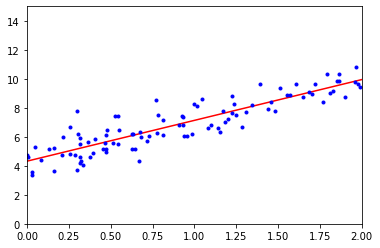

In [8]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b. ")
plt.axis([0, 2, 0, 15])
plt.show()

In [ ]:
# 사이킷런에서 선형 회귀 수행
# 사이킷런은 특성의 가중치(coef_)와 편향(intercept_)을 분리하여 저장함
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.56903127]), array([[3.29550967]]))

In [ ]:
lin_reg.predict(X_new)

array([[ 3.56903127],
       [10.16005061]])

In [ ]:
# LinearRegression 클래스는 직접 호출 가능한 scipy.linalg.lstsq() 함수를 기반으로 함
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.56903127],
       [3.29550967]])

> $\hat{\theta} = X^+ y$을 계산하는 함수($X^+$ :  $X$의 유사역행렬)

In [ ]:
# np.linalg.pinv() 함수를 사용해 유사역행렬 직접 구하기
np.linalg.pinv(X_b).dot(y)

array([[3.56903127],
       [3.29550967]])

> - 유사역행렬은 **특잇값 분해**(SVD)을 사용해 계산

###**4.1.2 계산 복잡도**
- 정규 방정식은 $(n+1) \times (n+1)$ 크기인 $X^TX$의 역행렬을 계산
  + 역행렬을 계산하는 계산 복잡도는 일반적으로 $O(n^{2.4})$~$O(n^{3})$ 사이

- 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 $O(n^{2})$

- 학습된 선형 회귀 모델은 예측이 매우 빠름
- 예측 계산 복잡도는 샘플 수와 특성 수에 선형적
  + 즉, 샘플(특성)이 두 배로 늘어나면 걸리는 시간도 거의 두 배 증가

###**4.2 경사 하강법**
- 경사 하강법(GD): 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
  + 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정
  + 파라미터 벡터 $\theta$에 대해 비용 함수의 현재 그레이디언트 계산
    + 그레이디언트가 감소하다 0이 되면 최솟값에 도달한 것
  + $\theta$를 임의의 값으로 시작(무작위 초기화) > 조금씩 비용 함수를 감소하는 방향으로 진행하여 알고리즘이 최솟값에 수렴
  + 중요한 파라미터는 스텝의 크기로, 학습률 하이퍼파라미터로 결정
    + 학습률이 너무 작으면 반복이 많이 진행되어 시간이 오래 걸림
    + 학습률이 너무 크면 최솟값을 건너 뛰어 더 큰 값을 가짐


- 경사 하강법의 문제점(비용 함수에 다양한 형태 존재)
  + 무작위 초기화로 인해 전역 최솟값이 아닌 지역 최솟값에 수렴할 수 있음
  + 무작위 초기화로 인해 최솟값과 먼 곳에서 시작하여 시간이 오래 걸리고 일찍 멈춰 최솟값에 도달하지 못할 수 있음
  + MSE 비용 함수는 볼록함수 이므로 위의 문제가 발생하지 않음

- 경사 하강법 최적화
  + 모델 훈련: 훈련 세트에서 비용 함수를 최소화하는 모델 파라미터의 조합을 찾는 것
  + 모델의 파라미터 공간에서 찾는다<라고 표현

  + 모델의 파라미터 수가 많을수록 공간의 차원은 커지고 검색이 어려워짐

###**4.2.1 배치 경사 하강법**
- 경사 하강법을 구현하기 위해서는 각 모델 파라미터 $\theta_j$에 대해 비용 함수의 그레이디언트를 계산해야함: 편도함수(partial derivative)
$$ \frac{\partial}{\partial \theta_j}MSE(\theta) = \frac{2}{m}\sum_{i=1}^{m} (\theta^T x^{(i)} - y^{(i)}) x_{j}^{(i)}$$
  + 편도함수를 각각 계산할 필요 없이 한번에 계산 가능
  $$ \nabla_{\theta} MSE(\theta)= \begin{pmatrix} \frac{\partial}{\partial \theta_0}MSE(\theta)  \\ \frac{\partial}{\partial \theta_1}MSE(\theta) \\ ... \\ \frac{\partial}{\partial \theta_n}MSE(\theta) \end{pmatrix} = \frac{2}{m}X^T(X\theta - y)$$
  + 이때, 위로 향하는 그레이디언트 벡터가 구해지면 반대 방향인 아래로 가기 위해 학습률 사용
  $$ \theta^{(next step)} = \theta - \eta \nabla_{\theta} MSE(\theta)$$

In [ ]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 무작위 초기화화

for iteration in range(n_iterations):
    gradients = 2/m * x_b.T.dot(x_b.dot(theta) - y)
    theta = theta - eta * gradients

In [ ]:
theta

array([[3.56903127],
       [3.29550967]])

> 학습률 $\eta$를 바꿔서 수행하면 수행 시간과 수렴 여부가 달라짐
  + 적절한 학습률을 찾기 위해 그리드 탐색 사용(너무 오래 걸리는 것을 막기 위해 반복 횟수 제한)
  + 반복 횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면(허용오차보다 작을 때) 경사 하강법이 거의 최솟값에 도달한 것이므로 알고리즘을 중지


###**4.2.2 확률적 경사 하강법**
- 배치 경사 하강법의 가장 큰 문제: 매 스텝에서 전체 훈련 세트를 사용해 그레이디언트를 계산한다는 사실
  + 훈련 세트가 커지면 속도가 매우 느려짐

- 확률적 경사 하강법: 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트를 계산
  + 다뤄야 할 데이터가 매우 적기 때문에 알고리즘의 속도가 더 빠름
  + 반면 확률적이기 때문에 배치 경사 하강법보다 불안정
    + 비용 함수가 최솟값에 다다를 때까지 부드럽게 감소하지 않고 위아래로 요동치면서 평균적으로 감소(최적치가 아님)
    + 배치 경사하강법보다 지역 최솟값을 건너뛰어 전역 최솟값을 가능성이 높음

- 학습률을 점진적으로 감소시켜 위의 문제 해결 가능
  + 담금질 기법 알고리즘과 유사
  + 학습 스케줄: 매 반복에서 학습률을 결정하는 함수
  + 이때 학습률이 너무 천천히 감소하면 훈련을 일찍 종료하여 지역 최솟값에 머물수도 있음음

In [ ]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 무작위 초기화화

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = x_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

> - 에포크; 한 반복에서 m번 되풀이되고, 이때의 각 반복을 의미함함

In [ ]:
theta

array([[3.59058742],
       [3.33172816]])

- 샘플을 무작위로 선택하기 때문에 샘플은 한 에포크에서 여러 번 선택될 수 있고 전혀 선택되지 못할 수도 있음
  + 모든 샘플을 사용하게 하기 위해 훈련 세트를 섞은 후 차례대로 하나씩 선택 후 다음 에포크에서 다시 섞는 방법 사용(수렴에 걸리는 시간은 더 늘어남)

- 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스 사용

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(x, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [ ]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.53466672]), array([3.27952595]))

###**4.2.3 미니배치 경사 하강법**
- 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트 계산
  + 행렬 연산에 최적화된 하드웨어(GPU)를 사용해서 성능을 향상시킴
- 미니배치 경사 하강법은 SGD보다 최솟값에 더 가까이 도달하지만 지역 최솟값에서 빠져나오기 힘들다는 단점이 있음
  + 적절한 학습 스케줄을 사용하면 최솟값에 도달 가능

###**4.3 다항 회귀**
- 다항 회귀: 데이터가 비선형 데이터일 때, 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 특성을 모두 포함한 데이터셋에 선형 모델을 훈련시키는 기법

In [ ]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

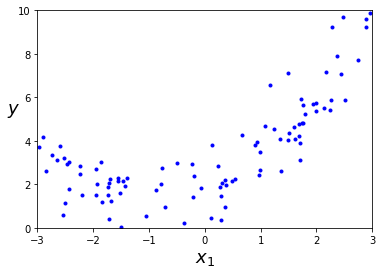

In [ ]:
plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

> 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터 변환 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)
x[0]

array([-2.42902892])

In [ ]:
x_poly[0]

array([-2.42902892,  5.9001815 ])

> - x_poly는 원래의 특성 x와 이 특성의 제곱 포함
    + Linear Regression 적용용

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.81073394]), array([[1.01378509, 0.52422398]]))

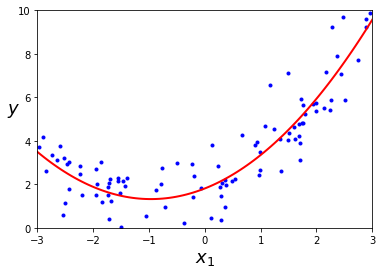

In [ ]:
x_new=np.linspace(-3, 3, 100).reshape(100, 1)
x_new_poly = poly_features.transform(x_new)
y_new = lin_reg.predict(x_new_poly)

plt.plot(x, y, "b.")
plt.plot(x_new, y_new, "r-", linewidth=2)

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

> - 다항 회귀는 특성 사이의 관계를 찾을 수 있음
    + PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문


###**4.4 학습 곡선**
- 고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 더 훈련 데이터에 잘 맞춰짐
- 모델이 과대적합/과소적합 됐는지 확인을 위해 학습 곡선을 살펴볼 수 있음
  + 학습 곡선: 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄

In [ ]:
# 학습 곡선 그리는 함수 정의
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="valid set")

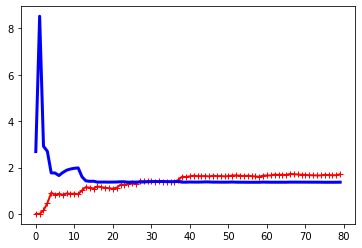

In [ ]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, x, y)

> - 위의 학습 곡선은 과소적합 모델의 전형적인 모습
    + 곡선이 어느 정도 평편해질 때까지 오차가 계속 상승
    + 훈련 샘플이 추가됨에 따라 학습이 되어 검증 오차는 천천히 감소 

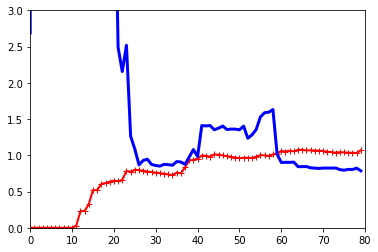

In [ ]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, x, y)
plt.axis([0, 80, 0, 3])  

plt.show() 

> - 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
  - 두 곡선 사이에 공간 존재
    + 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 과대적합 모델의 특징
    + 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐짐

###**4.5 규제가 있는 선형 모델**
- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것(모델 제한)
  + 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함

###**4.5.1 릿지 회귀**
- 릿지 회귀: 규제항  $\alpha \sum^n_{i=1} \theta_i^2$가 비용 함수에 추가
  + 모델의 가중치가 가능한 한 작게 유지되도록 노력
  + 규제항은 훈련 동안에만 비용 함수에 추가
  + 모델의 훈련이 끝난 후에는 모델의 성능을 규제가 없는 성능 지표로 평가

- 하이퍼파라미터 $\alpha$는 모델을 얼마나 많이 규제할지 조절
  + $\alpha = 0$의 릿지 회귀는 선형 회귀와 동일
  + $\alpha$의 값이 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 됨

- 릿지 회귀의 비용 함수
$$ J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum^n_{i=1} \theta^2_i$$

  + 편향 $\theta_0$은 규제되지 않음
  + w를 특성의 가중치 벡터라고 정의할 때, 규제항은 $1/2( \lvert \lvert w \rvert \rvert_2)^2$와 동일일
  + 경사 하강법에 적용하려면 MSE의 그레디언트에 $\alpha$w를 더함

- $\alpha$가 증가할수록 직선에 가까워짐
  + 모델의 분산 감소, 편향 증가

- 선형 회귀와 마찬가지로, 릿지 회귀에 정규방정식, 경사 하강법 사용 가능

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(x, y)
ridge_reg.predict([[1.5]])

array([[4.82656862]])

In [ ]:
# 확률적 경사 하강법 사용
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(x, y.ravel())
sgd_reg.predict([[1.5]])

array([4.80326766])

> - penalty 매개변수는 사용할 규제 지정
    + "l2"는 릿지회귀를 의미


###**4.5.2 라쏘 회귀**
- 라쏘 회귀: 릿지 회귀처럼 비용 함수에 규제항을 더하지만 가중치 벡터의 노름을 사용
$$J(\theta) = MSE(\theta) + \alpha \sum^n_{i=1} \lvert \theta_i \rvert$$
- 덜 중요한 특성의 가중치를 제거하려고 한다는 특징이 있음
  + 즉, 자동으로 특성 선택을 하고 희소 모델을 생성

- 릿지 회귀, 라쏘 회귀의 비용 함수 차이점
  + 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아짐
    + 즉, 경사 하강법이 자동으로 느려져 수렴에 도움됨
  + $\alpha$를 증가시킬수록 최적의 파라미터가 원점에 가까워짐(0이 되진 않음)

- 라쏘의 비용 함수는 $\theta_i = 0$일 때 미분 불가능
  + 서브그레이디언트 벡터 $g$를 사용하면 경사 하강법을 적용할 수 있음
  + 서브그레이디언트 벡터 공식
  $$g(\theta, J)= \nabla_{\theta} MSE(\theta) + \alpha 
\begin{pmatrix}
sign(\theta_1)  \\
sign(\theta_2)  \\ ... \\ 
sign(\theta_n) \end{pmatrix}
,sign(\theta_i)
\begin{cases} 
-1,\;if\; \theta_i < 0\\
0,\;if\;\theta_i = 0\\
1,\;if\;\theta_i > 0
\end{cases}$$

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(x, y)
lasso_reg.predict([[1.5]])

array([4.78172392])

> - Lass0 대신 SGDRegressor(penalty="l1") 사용 가능

###**4.5.3 엘라스틱넷**
- 엘라스틱넷: 릿지 회귀와 라쏘 회귀를 절충한 모델
  + 혼합 정도는 혼합 비율$r$을 사용해 조절
  + $r = 0$이면 릿지 회귀, $r = 1$이면 라쏘 회귀와 동일

- 엘라스틱넷의 비용 함수
$$J(\theta) = MSE(\theta) + r\alpha \sum^n_{i=1} \lvert \theta_i \rvert + \frac{1-r}{2} \alpha \sum^n_{i=1} \theta^2_i$$

- 규제가 약간 있는 것이 대부분의 경우에 좋으므로 일반적으로 평범한 선형 회귀는 피해야함
  + 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷 사용
  + 릿지나 엘라스틱넷은 불필요한 특성의 가중치를 0으로 만듦
  + 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 떄는 보통 라쏘보다는 엘라스틱넷 선호 

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(x, y)
elastic_net.predict([[1.5]])

array([4.78392534])

###**4.5.4 조기 종료**
- 경사 하강법과 같은 반복적인 학습 알고리즘을 규제하는 또 다른 방법은 검증 에러가 최솟값에 도달하면 바로 훈련을 중지 시키는 것
  + 모델이 훈련 데이터에 과대적합하기 전, 즉 에러가 최소에 도달하는 즉시 훈련을 멈춤 

In [ ]:
# 조기 종료를 위한 기본적인 구현 코드

from copy import deepcopy
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val = train_test_split(x[:50], y[:50].ravel(), test_size=0.5, random_state=10)

# 데이터 준비
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

> SGDRegressor의 tol 파라미터 오류,, None으로 설정해서 해결

- warm_start = True로 지정하면 fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어감

###**4.6 로지스틱 회귀**
- 로지스틱 회귀: 회귀 알고리즘을 분류에서 사용할 수 있게함
  + 추정 확률이 50%가 넘어가면 샘플이 해당 클래스에 속한다고 예측(양성 클래스)
  + 반대의 경우 속하지 않는다고 예측(음성 클래스)
  + 이를 이진 분류기라고 함


###**4.6.1 확률 추정**
- 로지스틱 회귀 모델은 선형 회귀와 마찬가지로 입력 특성의 가중치 합을 계산 후 편향을 더함
  + 그러나 바로 결과를 출력하지 않고 결괏값의 로지스틱을 출력
  $$\hat{p} = h_{\theta}(x) = \sigma(\theta^T x)$$

- 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수
$$ \sigma(t) = \frac{1}{1 + exp(-t)}$$

- 로지스틱 회귀 모델이 샘플x가 양성 클래스에 속핳 롹률을 추정하면 이에 대한 예측을 쉽게 구할 수 있음
  + $\theta^T x$가 양수일 때 1, 음수일 때 0으로 예측


###**4.6.2 훈련과 비용 함수**
- 훈련의 목적은 양성 샘플에 대해서는 높은 확률을 추정하고, 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것
$$c(\theta)=
\begin{cases}
-log(\hat{p}),\;if\;y=1\\
-log(1-\hat{p}),\;if\; y=0
\end{cases}$$

- 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것
  + 이른 로그 손실이라고 부름
  $$J(\theta)= - \frac{1}{m} \sum_{i=1}^m [y^{(i)}log(\hat{p}^{(i)})
+ (1-y^{(i)})log(1-\hat{p}^{(i)})]$$

- 이 비용 함수의 최솟값을 계산하는 알려진 해는 없음
  + 그러나 비용 함수가 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾는다는 것을 보장함
  + 비용 함수의 j번째 모델 파라미터 $\theta_j$에 대해 편미분한 식
  $$ \frac{\partial}{\partial \theta_j}J(\theta)= \frac{1}{m} \sum_{i=1}^m(\sigma (\theta^T x^{(i)}) - y^{(i)})x_j^{(i)}$$

  + 모든 편도함수를 포함한 그레이디언트 벡터를 만들면 배치 경사 하강법 알고리즘 사용 가능


###**4.6.3 결정 정계**
- 로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋 사용
  + 꽃잎 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기 생성

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int) # Iris-virginica이면 1, 그렇지 않으면 0

<ipython-input-41-035f28acbfa0>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int) # Iris-virginica이면 1, 그렇지 않으면 0


In [ ]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

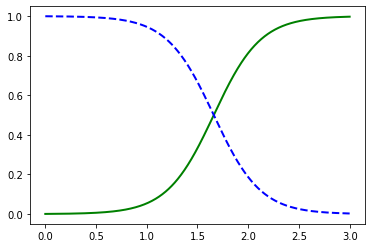

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

> - 약간 중첩되는 부분이 있지만 꽃잎 너비가 2cm 이상인 꽃은 분류기가 Iris-Verginica라고 강하게 확신, 1cm 이하면 아니라고 확신
- 두 극단 사이에서는 분류가 확실하지 않지만 가장 가능성 높은 클래스를 반환
  + 양쪽의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계가 생성됨됨

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

###**4.6.3 소프트맥스 회귀**
- 소프트맥스 회귀(다항 로지스틱 회귀): 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화된 것

- 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 $s_k(x)$를 계산하고, 그 점수에 소프트맥스 함수(정규화된 지수 함수)를 적용하여 각 클래스의 확률 추정
$$s_k(x) = (\theta^{(k)})Tx$$

- 각 클래스는 자신만의 파라미터 벡터 $\theta^(k)$가 존재
  + 이 벡터들은 파라미터 행렬에 행으로 저장

- 샘플 x에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 확률 $\hat{p_k}$를 추정 가능
  + 로그-오즈라고 부름름
$$\hat{p_k} = \sigma(s(x))_k = \frac{exp(s_k (x))}{\sum_{i=1}^K exp(s_j(x))}$$
    + K는 클래스 수
    + $s(x)$는 샘플 x에 대한 각 클래스의 점수를 담은 벡터
    + $\sigma(s(x))_k$는 샘플 x에 대한 각 클래스의 점수가 주어졌을 때 이 샘플이 클래스 k에 속할 추정 확률

- 로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회귀 분류기는 추정 확률이 가장 높은 클래스를 선택택
$$\hat{y} = argmax \sigma(s(x))_k = argmax s_k(x) = argmax ((\theta^{(k)})^T x)$$

- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목적
  + 크로스 엔트로피 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합 
  + 크로스 엔트로피 비용 함수
  $$J(\theta) = - \frac{1}{m}
\sum_{i=1}^m
\sum_{k=1}^K y_k^{(i)} log(\hat{p}_k^{(i)})$$
    + 두 개의 클래스가 있을 때(K=2) 이 비용 함수는 로지스틱 회귀의 비용 함수와 동일
  + 비용 함수의 $\theta^(k)$에 대한 그레이디언트 벡터
  $$ \nabla_{\theta^{(k)}}J(\theta_{big}) = - \frac{1}{m}
\sum_{i=1}^m 
(\hat{p}_k^{(i)} - y_k^{(i)})x^{(i)}$$

- 소프트맥스 회귀를 사용해 붓꽃을 세 개의 클래스로 분류
  + Logistic Regression의 multi_class 매개변수를 "multinomial"로 바꿔 소프트맥스 회귀 사용
  + solver 매개변수에 "lbgfs"와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 함
  + 기본적으로 $l_2$ 규제 사용

In [ ]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [ ]:
softmax_reg.predict([[5,2]])

array([2])

In [ ]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

> - 클래스 사이의 결정 경계는 모두 선형
    + 모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가짐 